# Python notebook demonstrating streaming OnlineGCP applied to Chicago Crime data
Demonstrates results similar to those found in the paper Eric T. Phipps, Nicholas T. Johnson, and Tamara G. Kolda. 2023. 
Streaming Generalized Canonical Polyadic Tensor Decompositions. In Proceedings of the Platform for Advanced Scientific Computing Conference (PASC '23).
[https://doi.org/10.1145/3592979.3593405](https://dl.acm.org/doi/10.1145/3592979.3593405).

It requires downloading the Chicago Crime data, which can be obtained from [FROSTT](http://frostt.io/tensors/chicago-crime/).

Note that because of the large number of time slices in the data, this takes a while to run (> 1 hour) on most platforms.

### Import needed modules
Generally better performance is obtained on CPU architectures with OpenMP parallelism when pygenten is imported before pyttb/numpy.

In [1]:
import pygenten as gt
import pyttb as ttb
import numpy as np
import matplotlib.pyplot as plt
import copy as cpy

### Define some utility functions 
OnlineGCP requires the streaming temporal mode to be the last mode, and we sort the tensor with increasing time index to make splitting the tensor along that mode efficient.

In [2]:
def t_slice(u,t):
    # take a slice of a ktensor from a given t index
    ut = u.copy()
    tmp = ut.factor_matrices[-1]
    tmp = np.reshape(tmp[t,:],(1,-1))
    ut.factor_matrices[-1] = tmp
    return ut
    
def binary_reconstruction_error(u,X):
    # Compute reconstruction error between U and X for each time slice.
    # u is a ktensor
    # X is a list of tensor slices
    nt = u.shape[-1]
    r = np.zeros(nt)
    for t in range(nt):
        u_t = t_slice(u,t)
        U_t = u_t.full().data
        X_t = X[t].full().data
        r[t] = np.sum(np.log(U_t+1)-X_t*np.log(U_t+1e-10)) / X[t].norm()**2
    return r

def sort_tensor(X):
    # sort tensor with increaasing time mode
    subs = X.subs
    vals = X.vals
    t = subs[:,3]
    ind = np.argsort(t,kind='stable')
    sorted_subs = subs[ind,:]
    sorted_vals = vals[ind]
    sorted_X = ttb.sptensor(sorted_subs,sorted_vals,X.shape,False)
    return sorted_X

def split_tensor(X):
    # Split a tensor along the time mode where each tensor has a single value for the time mode.
    # Assumes the tensor is already sorted along the time mode.
    # Returns an array of sptensors split along the time mode

    # Find where time index changes and split where that happens
    subs = X.subs.copy() # Need to make copies because split below returns views and we don't want to modify X
    vals = X.vals.copy()
    t = subs[:,3]
    splits = np.where(np.diff(t)!=0)[0]+1
    split_subs = np.split(subs,splits,axis=0)
    split_vals = np.split(vals,splits)

    # set time index to 0 in each split
    for s in split_subs:
        s[:,3] = 0

    # make sptensors, including a length-1 time-mode
    shape = X.shape[0:3] + (1,)
    slices = [ ttb.sptensor(s,v,shape) for s,v in zip(split_subs,split_vals) ]
    return slices

### Read and preprocess the data

In [3]:
fname = 'chicago-crime-comm.tns'   # Data file from FROSTT
start_time = 500                   # Number of time steps to drop (early times have very little volume)
num_warm = 10                      # Number of time steps in the warm start
rank = 50                          # Rank of the CP decompositions

# read data (we use this approach because it doesn't require a header in the file, whereas ttb.import_data() does, and the file comes from FROSTT without a header)
X = gt.make_ttb_sptensor(gt.import_sptensor(fname,index_base=1)) 
X = X.permute(np.array((1,2,3,0))) # reorder modes to move time mode to the last as required by the streaming algorithm
X = sort_tensor(X)                 # sort tensor along time mode (mode 3)
X = X[:,:,:,start_time:]           # drop early slices due to low volume
X = X.elemfun(lambda vals: np.ones(vals.shape)) # replace nonzero values with 1s for binary
X0 = X[:,:,:,0:num_warm]           # data for warm-start
slices = split_tensor(X)           # partition data into slices, making sure to keep an explicit time mode as required by streaming algorithm

### Generate warm start

In [4]:
gcp_params = dict()
gcp_params['type'] = 'bernoulli'
gcp_params['sampling'] = 'semi-stratified'
gcp_params['fnzs'] = 50000
gcp_params['fzs'] = 50000
gcp_params['gnzs'] = 10000
gcp_params['gzs'] = 10000
gcp_params['hash'] = True
gcp_params['fuse'] = True
gcp_params['maxiters'] = 100
gcp_params['fails'] = 2
u_init,_,_ = gt.gcp_sgd(X0,rank=rank,**gcp_params)
u_init.normalize(None).redistribute(3) # normalize factor matrix columns and put all weight in time mode
reconstruction_init = binary_reconstruction_error(u_init,slices)


Sparse tensor: 
  24 x 77 x 32 x 10 (591360 total entries)
  12268 (2.1%) Nonzeros and 579092 (97.9%) Zeros
  1.1e+02 Frobenius norm

Execution environment:
  MPI grid: 1 x 1 x 1 x 1 processes (1 total)
  Execution space: openmp (8 threads)

GCP-SGD (Generalized CP Tensor Decomposition):
Generalized function type: Bernoulli (binary)
Optimization method: adam
Max iterations (epochs): 100
Iterations per epoch: 1000
Traditional annealer, learning rate: 1.0e-03, decay: 1.0e-01
  Function sampler:  stratified with 12268 nonzero and 50000 zero samples
  Gradient sampler:  semi-stratified with 10000 nonzero and 10000 zero samples
  Gradient nonzero samples per epoch: 10000000 (81512.9%)
Gradient method: Fused sampling and duplicated MTTKRP

Hashing tensor for faster sampling...0.0 seconds
Initial f-est:  1.021208e+05, tensor norm:  1.108e+02
Epoch   1: f-est =  3.979099e+04, step =  1.0e-03, time = 1.34e+00 sec
Epoch   2: f-est =  3.807044e+04, step =  1.0e-03, time = 2.66e+00 sec
Epoch   3:

### Compute static gcp decomposition

In [5]:
gcp_params = dict()
gcp_params['type'] = 'bernoulli'
gcp_params['sampling'] = 'semi-stratified'
gcp_params['fnzs'] = 100000
gcp_params['fzs'] = 100000
gcp_params['gnzs'] = 10000
gcp_params['gzs'] = 10000
gcp_params['hash'] = True
gcp_params['fuse'] = True
gcp_params['maxiters'] = 100
gcp_params['fails'] = 2
u_static_gcp,_,_ = gt.gcp_sgd(X,rank=rank,**gcp_params)
reconstruction_static_gcp = binary_reconstruction_error(u_static_gcp,slices)


Sparse tensor: 
  24 x 77 x 32 x 5686 (3.36e+08 total entries)
  5288704 (1.6%) Nonzeros and 330958592 (98.4%) Zeros
  2.3e+03 Frobenius norm

Execution environment:
  MPI grid: 1 x 1 x 1 x 1 processes (1 total)
  Execution space: openmp (8 threads)

GCP-SGD (Generalized CP Tensor Decomposition):
Generalized function type: Bernoulli (binary)
Optimization method: adam
Max iterations (epochs): 100
Iterations per epoch: 1000
Traditional annealer, learning rate: 1.0e-03, decay: 1.0e-01
  Function sampler:  stratified with 100000 nonzero and 100000 zero samples
  Gradient sampler:  semi-stratified with 10000 nonzero and 10000 zero samples
  Gradient nonzero samples per epoch: 10000000 (189.1%)
Gradient method: Fused sampling and duplicated MTTKRP

Hashing tensor for faster sampling...0.1 seconds
Initial f-est:  5.004946e+07, tensor norm:  2.300e+03
Epoch   1: f-est =  1.977121e+07, step =  1.0e-03, time = 2.61e+00 sec
Epoch   2: f-est =  1.938159e+07, step =  1.0e-03, time = 5.06e+00 sec
E

### Compute streaming GCP decomposition

In [6]:
# temporal sgd solver params
temporal_params = dict()
temporal_params['sampling'] = 'stratified'
temporal_params['fnzs'] = 10000
temporal_params['fzs'] = 10000
temporal_params['gnzs'] = 1000
temporal_params['gzs'] = 1000
temporal_params['hash'] = True
temporal_params['fuse'] = True
temporal_params['maxiters'] = 5
temporal_params['fails'] = 3
temporal_params['epochiters'] = 100
temporal_params['rate'] = 1e-1
temporal_params['gcp-tol'] = 1e-5

# spatial sgd solver params
spatial_params = cpy.deepcopy(temporal_params)
spatial_params['maxiters'] = 5
spatial_params['rate'] = 1e-3

# streaming solver params
gcp_params = dict()
gcp_params['streaming-solver'] = 'sgd'
gcp_params['type'] = 'bernoulli'
gcp_params['rank'] = rank
gcp_params['window-size'] = 500
gcp_params['window-penalty'] = 10
gcp_params['window-method'] = 'reservoir'
gcp_params['printitn'] = 10

# compute streaming gcp decomposition
u_gcp,fest,ften = gt.online_gcp(slices[num_warm:],X0,u_init,temporal_params,spatial_params,**gcp_params)
u_gcp.normalize(None).redistribute(3)
u_gcp.factor_matrices[-1] = np.vstack((u_init.factor_matrices[-1],u_gcp.factor_matrices[-1]))
global_reconstruction_gcp = binary_reconstruction_error(u_gcp,slices)
local_reconstruction_gcp = list(reconstruction_init) + [ f/s.norm()**2 for f,s in zip(ften,slices) ]


Online-GCP (Online Generalized CP Tensor Decomposition)

Rank: 50
Generalized function type: Bernoulli (binary)
Streaming window size: 500 (reservoir), penalty: 1.00e+01 * ( 1.00e+00 )^(T-t)

Processing slice 10 of 5676
Solving for temporal mode...
Hashing tensor for faster sampling...6.09e-04 seconds
Initial f-est:  4.457378e+03, tensor norm:  3.624e+01
Epoch   1: f-est =  4.396664e+03, step =  1.0e-01, time = 3.89e-02 sec
Epoch   2: f-est =  4.406307e+03, step =  1.0e-01, time = 7.68e-02 sec, nfails = 1 (resetting to solution from last epoch)
Epoch   3: f-est =  4.394132e+03, step =  1.0e-02, time = 1.14e-01 sec
Epoch   4: f-est =  4.392233e+03, step =  1.0e-02, time = 1.52e-01 sec
Epoch   5: f-est =  4.392166e+03, step =  1.0e-02, time = 1.90e-01 sec
Updating spatial modes...
Hashing tensor for faster sampling...6.09e-04 seconds
Initial f-est:  4.352699e+03, tensor norm:  3.624e+01
Epoch   1: f-est =  4.281488e+03, step =  1.0e-03, time = 1.20e-01 sec
Epoch   2: f-est =  4.279975e+

### Plot the local and global reconstruction (Bernoulli) loss
Local loss is the loss computed for each time slice using the factor matrices as they were after each streaming step.  Global loss is the loss for each time slice using the factor matrices at the end of the computation.

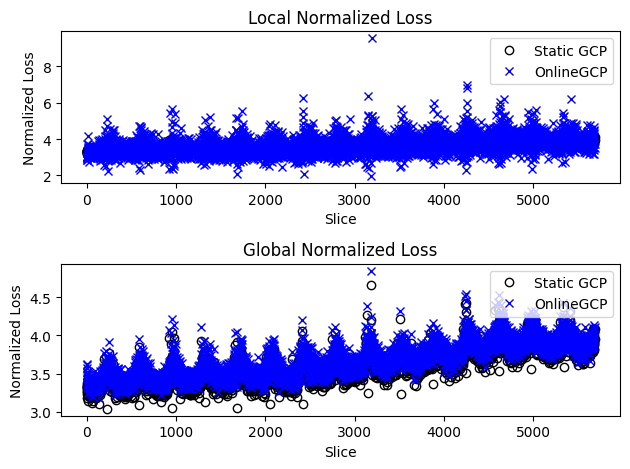

In [7]:
fig, axs = plt.subplots(2,1)
axs[0].plot(reconstruction_static_gcp, 'ko', label='Static GCP', markerfacecolor='none')
axs[0].plot(local_reconstruction_gcp, 'bx', label='OnlineGCP', markerfacecolor='none')
axs[0].set_title('Local Normalized Loss')
axs[0].set_xlabel('Slice')
axs[0].set_ylabel('Normalized Loss')
axs[0].legend(loc='upper right')

axs[1].plot(reconstruction_static_gcp, 'ko', label='Static GCP', markerfacecolor='none')
axs[1].plot(global_reconstruction_gcp, 'bx', label='OnlineGCP', markerfacecolor='none')
axs[1].set_title('Global Normalized Loss')
axs[1].set_xlabel('Slice')
axs[1].set_ylabel('Normalized Loss')
axs[1].legend(loc='upper right')

fig.tight_layout()